In [1]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 50.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd
import numpy as np

In [5]:
# setting A
df_train_r = pd.read_csv('gpt3_reasoning_train.csv')
df_dev_r = pd.read_csv('gpt3_reasoning_dev.csv')
df_test_r = pd.read_csv('gpt3_reasoning_test.csv')


In [6]:
df_train_r=df_train_r[['Reply_id','clean_reason']].copy()
df_dev_r=df_dev_r[['Reply_id','clean_reason']].copy()
df_test_r=df_test_r[['Reply_id','clean_reason']].copy()

In [7]:
# setting A
df_train = pd.read_csv('TR_a.csv')
df_train=df_train.rename(columns={"gold_adj": "gold"})

df_dev = pd.read_csv('TD_a.csv')
df_dev=df_dev.rename(columns={"gold_adj": "gold"})

df_test = pd.read_csv('TE_a.csv')
df_test=df_test.rename(columns={"gold_adj": "gold"})

In [8]:
df_train=pd.merge(df_train,df_train_r,on='Reply_id')
df_dev=pd.merge(df_dev,df_dev_r,on='Reply_id')
df_test=pd.merge(df_test,df_test_r,on='Reply_id')

In [9]:
df_train['QA'] = df_train['Main_tweet'] + '[SEP]' + df_train['Reply_tweet'] + df_train['clean_reason']
df_dev['QA'] = df_dev['Main_tweet'] + '[SEP]' + df_dev['Reply_tweet'] + '[SEP]' + df_dev['clean_reason']
df_test['QA'] = df_test['Main_tweet'] + '[SEP]' + df_test['Reply_tweet'] + '[SEP]' +df_test['clean_reason']

In [10]:
df_dev=df_dev.astype(str)
df_train=df_train.astype(str)
df_test=df_test.astype(str)


In [11]:
df_test['gold'].value_counts()

y     236
n     155
uk    109
py     69
pn     31
Name: gold, dtype: int64

In [12]:
y_dev = pd.get_dummies(df_dev.gold, prefix='gold')
y_dev

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,0,1
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
595,0,0,0,0,1
596,0,1,0,0,0
597,1,0,0,0,0
598,0,0,0,0,1


Roberta Init

In [13]:
# Changed to roberta

bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

In [14]:
# RoBerta layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# Neural network layers
# l = tf.keras.layers.Dense(50, activation='sigmoid', name="output")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(6, activation='softmax', name="soft_output")(l)

# # adding drop out layer
# l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(l)

#use this if without dropout, instead of the two layers above
l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [16]:
import keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate # I use ._decayed_lr method instead of .lr
    return lr


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01, restore_best_weights=True)

initial_learning_rate = 0.00002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(optimizer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      lr_metric
]

# optimizer.learning_rate.assign(0.00002)
model.compile(optimizer=optimizer,
              loss='CategoricalCrossentropy',
              metrics=METRICS)

In [17]:
df_circa = pd.read_excel(r'circa_train.xlsx')
df_twitter=df_train

In [18]:
df_twitter.isna().sum()

Unnamed: 0          0
Main_Tweet_ID       0
Reply_id            0
temporal_setting    0
Main_tweet          0
Reply_tweet         0
gold_1              0
gold_2              0
gold                0
clean_reason        0
QA                  0
dtype: int64

In [19]:
df_circa.columns

Index(['Unnamed: 0', 'id', 'context', 'question-X', 'canquestion-X',
       'answer-Y', 'judgements', 'goldstandard1', 'goldstandard2'],
      dtype='object')

In [20]:
df_circa['goldstandard1'] = df_circa['goldstandard1'].replace(np.nan, 'N/A')
df_circa['goldstandard1'] = df_circa['goldstandard1'].astype(str)

df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Yes, subject to some conditions', 'py')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Probably yes / sometimes yes','py')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Probably no','pn')

df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('In the middle, neither yes nor no','uk')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('I am not sure how X will interpret Y’s answer','uk')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('N/A','uk')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Other','uk')

df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('No','n')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Yes','y')



In [21]:
# blend corpus
df_circa = df_circa.rename(columns={"goldstandard1": "gold"})
df_circa['QA'] = df_circa['question-X'] + '[SEP]' + df_circa['answer-Y'] 
df_circa = df_circa[['QA','gold']].copy()


df_circa = df_circa.rename(columns={"Goldstandard": "gold"})
df_circa['corpus_type'] = 'circa'

In [24]:
df_circa

,QA,gold,corpus_type
0,Will you be going to the big New Year's Eve pa...,uk,circa
1,Do you enjoy water sports?[SEP]I surf.,y,circa
2,Have you heard Mozart?[SEP]Of course,y,circa
3,Have you ever listened to Papa Roach?[SEP]I ha...,n,circa
4,Have you been well?[SEP]I was sick last week w...,n,circa
...,...,...,...
20555,Do you enjoy long books?[SEP]I can never get t...,pn,circa
20556,Do you listen to music on the radio?[SEP]I no ...,n,circa
20557,Did you read the Game of Thrones books?[SEP]I ...,n,circa
20558,"Have you ever been here before?[SEP]Once, long...",y,circa


In [25]:
df_twitter=df_twitter[['QA','gold']].copy()

In [26]:
df_twitter['corpus_type']='twitter'

In [27]:
df_twitter

,QA,gold,corpus_type
0,Do you work in coffee?[SEP] i often bath in co...,n,twitter
1,is it illegal to drive with a sheet mask on?[S...,y,twitter
2,Do you guys hate me?[SEP]'s account is tempora...,uk,twitter
3,Is it big coat weather?[SEP] i don't own a big...,uk,twitter
4,Is it weird that most of my Mother’s Day plans...,n,twitter
...,...,...,...
2195,Lawyers: is it legal to make attending a racia...,y,twitter
2196,POLL: Have you been vaccinated/do you plan to ...,n,twitter
2197,I got your back. Do you got mine?[SEP] always!...,y,twitter
2198,Is it just me but if you listen real hard do y...,n,twitter


In [28]:
df_twitter['gold'].value_counts()

y     871
n     718
uk    358
py    164
pn     89
Name: gold, dtype: int64

In [29]:
df_circa['gold'].value_counts()

y     8671
n     6446
uk    2397
py    2340
pn     706
Name: gold, dtype: int64

In [30]:
# y_dev = np.asarray(y_dev).astype(np.float32)


In [31]:
epochs = 200
val_loss = 100
patience = 0
alpha = 0.5
corpus_frac = 1 # initially
for e in range(epochs):

  df_train = pd.concat([df_twitter, df_circa.sample(frac = corpus_frac)])
  df_train = df_train.sample(frac = 1)
  y_train = pd.get_dummies(df_train.gold, prefix='gold')
  # y_train=y_train.reset_index().drop(['index'],axis=1)
  print(df_train.shape)
  print(y_train.shape)

  # # shortening blending corpus for quick sanity results
  # df_train = df_train.iloc[0:100]
  # y_train = y_train.iloc[0:100]
  # df_dev = df_dev.iloc[0:100]
  # y_dev = y_dev.iloc[0:100]

  corpus_frac = alpha * corpus_frac

  model.fit(df_train['QA'], y_train, epochs=1, batch_size=16, callbacks=[callback], validation_data = (df_dev['QA'], y_dev))
  if model.history.history['val_loss'][0] - val_loss <= 0.01:
    val_loss = model.history.history['val_loss'][0]
    saved_model = model
    patience = 0
  else:
    patience +=1
  if patience == 5:
    print('breaking now.....')
    break
  print('patience:',patience)
  print('epoch:',e)

(22760, 3)
(22760, 5)
1423/1423 [==============================] - 1162s 804ms/step - loss: 0.8097 - accuracy: 0.7125 - precision: 0.7939 - recall: 0.6180 - lr: 2.0000e-05 - val_loss: 1.0546 - val_accuracy: 0.5850 - val_precision: 0.6990 - val_recall: 0.4450 - val_lr: 2.0000e-05
patience: 0
epoch: 0
(12480, 3)
(12480, 5)
780/780 [==============================] - 666s 854ms/step - loss: 0.5957 - accuracy: 0.7917 - precision: 0.8483 - recall: 0.7320 - lr: 2.0000e-05 - val_loss: 1.0234 - val_accuracy: 0.6350 - val_precision: 0.7175 - val_recall: 0.5250 - val_lr: 2.0000e-05
patience: 0
epoch: 1
(7340, 3)
(7340, 5)
459/459 [==============================] - 436s 951ms/step - loss: 0.5577 - accuracy: 0.8065 - precision: 0.8579 - recall: 0.7542 - lr: 2.0000e-05 - val_loss: 1.0765 - val_accuracy: 0.6333 - val_precision: 0.7013 - val_recall: 0.5283 - val_lr: 2.0000e-05
patience: 1
epoch: 2
(4770, 3)
(4770, 5)
299/299 [==============================] - 318s 1s/step - loss: 0.4888 - accuracy: 0.

In [32]:
df_dev.isna().sum()

Unnamed: 0          0
Main_Tweet_ID       0
Reply_id            0
temporal_setting    0
Main_tweet          0
Reply_tweet         0
gold_1              0
gold_2              0
gold                0
clean_reason        0
QA                  0
dtype: int64

In [33]:
y_train['gold_uk'].value_counts()

0    2137
1     384
Name: gold_uk, dtype: int64

Dev set

In [35]:
y_dev = pd.get_dummies(df_dev.gold, prefix = 'gold')
print(saved_model.evaluate(df_dev['QA'], y_dev))
y_predicted = saved_model.predict(df_dev['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n', 
                                       'gold_pn',
                                       'gold_py',                     	
                                       'gold_uk',	
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_dev.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('DEV')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 26s 1s/step - loss: 1.8461 - accuracy: 0.6183 - precision: 0.6205 - recall: 0.5967 - lr: 2.0000e-05
[1.8461183309555054, 0.6183333396911621, 0.6204506158828735, 0.596666693687439, 2.000000313273631e-05]
19/19 [==============================] - 25s 1s/step
DEV
              precision    recall  f1-score   support

           n       0.70      0.70      0.70       185
          pn       0.22      0.31      0.26        13
          py       0.39      0.23      0.29        56
          uk       0.44      0.57      0.50       112
           y       0.73      0.68      0.71       234

    accuracy                           0.62       600
   macro avg       0.50      0.50      0.49       600
weighted avg       0.62      0.62      0.62       600



Test Set

In [36]:
df_test= df_test.rename(columns={"gold_adj": "gold"})
y_test = pd.get_dummies(df_test.gold, prefix = 'gold')
print(saved_model.evaluate(df_test['QA'], y_test))
y_predicted = saved_model.predict(df_test['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n', 
                                       'gold_pn',
                                       'gold_py',                     	
                                       'gold_uk',	
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 26s 1s/step - loss: 1.7980 - accuracy: 0.6217 - precision: 0.6334 - recall: 0.6133 - lr: 2.0000e-05
[1.798001766204834, 0.621666669845581, 0.6333907246589661, 0.6133333444595337, 2.000000313273631e-05]
19/19 [==============================] - 26s 1s/step
TEST
              precision    recall  f1-score   support

           n       0.63      0.73      0.67       155
          pn       0.33      0.16      0.22        31
          py       0.45      0.29      0.35        69
          uk       0.45      0.57      0.50       109
           y       0.77      0.73      0.75       236

    accuracy                           0.62       600
   macro avg       0.53      0.50      0.50       600
weighted avg       0.62      0.62      0.61       600



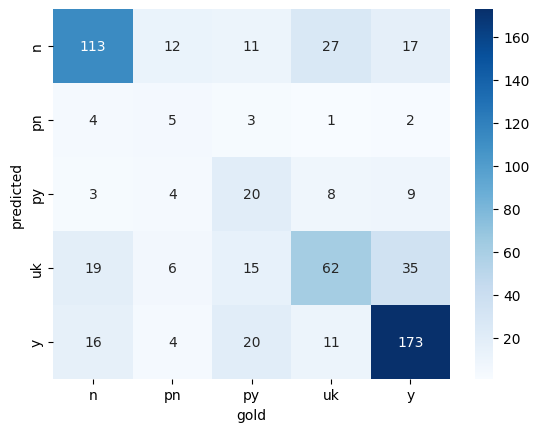

gold         n  pn  py  uk    y
predicted                      
n          113  12  11  27   17
pn           4   5   3   1    2
py           3   4  20   8    9
uk          19   6  15  62   35
y           16   4  20  11  173


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [38]:
pred_results = pred_results.rename(columns={"gold": "predict"})
pred_results['Main_Tweet_ID'] = df_test['Main_Tweet_ID']
pred_results['Reply_id'] = df_test['Reply_id']

In [39]:
pred_results['predict'].value_counts()

y     224
n     180
uk    137
py     44
pn     15
Name: predict, dtype: int64

In [40]:
pred_results.to_csv('A_circa_blend_reason.csv')